# Experiment 8b - Train ANN until model achieves 90% accuracy (on practiced tasks only)

In [60]:
import numpy as np
import torch
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from model import analysis
from importlib import reload
import tools
import pandas as pd
analysis = reload(analysis)
plt.rcParams['font.sans-serif'] = "Arial"

In [61]:
datadir = '../../data/model_results/experiment8/'
figuredir = '../figures/manuscriptFigures/Fig3_ANNPerformance/'
palette = sns.color_palette("Set2")


#### Sample commands for 3 networks
`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --rule2pretraining --practice --cuda --verbose --nsimulations 40`

`python experiment8_accuracyBenchmarkComparison.py --acc_cutoff 90 --nepochs 0 --practice --cuda --verbose --nsimulations 40`

# Load data and format dataframes

In [62]:
simstart = 0
simend = 40

#
df_adam = pd.DataFrame()
#
df_adam_1rule = pd.DataFrame()
#
df_adam_nopretraining = pd.DataFrame()

for i in range(simstart,simend):
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_2rulepretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_pretraining_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_90accCutOff_2layers_practice_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
    # Include zero-shot dataframes
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_2rulepretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Simple task pretraining',len(tmp))),True)
    df_adam = df_adam.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_pretraining_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Concept pretraining',len(tmp))),True)
    df_adam_1rule = df_adam_1rule.append(tmp)
    #
    tmp = pd.read_csv(datadir + 'expt8_adam_zeroshot_2layers_simData' + str(i) + '.csv')
    tmp.insert(len(tmp.columns),"Simulation",list(np.repeat(i,len(tmp))),True)
    tmp.insert(len(tmp.columns),"Training",list(np.repeat('Vanilla',len(tmp))),True)
    df_adam_nopretraining = df_adam_nopretraining.append(tmp)
    
df_all = pd.concat([df_adam_nopretraining,
                    df_adam_1rule,
                    df_adam])

# Transform accuracies to out of 100%
df_all.Accuracy = df_all.Accuracy.values * 100.0

##########
# Calculate total number of training samples/trials per simulation
df_all['TotalTrials'] = df_all[['NumPretrainingTrials', 'NumActualTrials']].sum(axis=1)
# Calculate "Effiency = Accuracy/Sample Size" -- but normalize accuracy and sample size to be $x \in [0,1]$
normalized_acc = (df_all['Accuracy']-df_all['Accuracy'].min())/(df_all['Accuracy'].max()-df_all['Accuracy'].min())
normalized_trainingsize = (df_all['TotalTrials'])/(df_all['TotalTrials'].max())
df_all['Learning inefficiency'] = (normalized_trainingsize)/(normalized_acc+5e-2)

##########
# Calculate average PS scores
df_all['PS1'] = df_all[['LogicPS1', 'SensoryPS1', 'MotorPS1']].mean(axis=1)
df_all['PS2'] = df_all[['LogicPS2', 'SensoryPS2', 'MotorPS2']].mean(axis=1)
df_all['PSavg'] = df_all[['PS1', 'PS2']].mean(axis=1)
df_all['Training'] = df_all['Training'].replace({'Concept pretraining': 'Primitives pretraining'})

## Accuracy vs. NumPracticedTasks

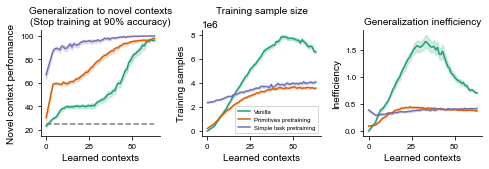

In [65]:
# prac_acc = df.loc[df['Condition']=='Practiced']
# rule2_acc = df.loc[df['Condition']=='2-rule overlap']
# rule1_acc = df.loc[df['Condition']=='1-rule overlap']
plt.figure(figsize=(6.9,2.5))
plt.subplot(1,3,1)
ax = sns.lineplot(x="NumPracticedTasks",y="Accuracy",hue="Training",data=df_all,palette="Dark2",legend=False)
plt.plot(np.arange(0,64),np.repeat(25,len(np.arange(0,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization to novel contexts\n(Stop training at 90% accuracy)', fontsize=10)
plt.xlabel('Learned contexts', fontsize=10)
plt.ylabel('Novel context performance', fontsize=10)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.ylim([15,105])
sns.despine()
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[1:4], labels[1:4],fontsize=6)

plt.subplot(1,3,2)
ax = sns.lineplot(x="NumPracticedTasks",y="TotalTrials",hue="Training",data=df_all,palette="Dark2")
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Training sample size', fontsize=10,y=1.1)
plt.xlabel('Learned contexts', fontsize=10)
plt.ylabel('Training samples', fontsize=10)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
sns.despine()
handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[1:4], labels[1:4],fontsize=6)
l = plt.legend(handles[0:4], labels[0:4],fontsize=6)

plt.subplot(1,3,3)
ax = sns.lineplot(x="NumPracticedTasks",y="Learning inefficiency",hue="Training",data=df_all,palette="Dark2",legend=False)
# plt.plot(np.arange(0,64),np.repeat(25,len(np.arange(0,64))),'gray',linestyle='--')
# plt.plot(np.arange(4,64),np.repeat(.80,len(np.arange(4,64))),'r',linestyle='--',label='Training cut-off on practice')
plt.title('Generalization inefficiency', fontsize=10)
plt.xlabel('Learned contexts', fontsize=10)
plt.ylabel('Inefficiency', fontsize=10)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
sns.despine()
# ax.set_yscale("log")
# plt.ylim([15,105])
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[1:4], labels[1:4],fontsize=6)

plt.tight_layout()
# plt.savefig('Expt8a_FixedEpochs.png',dpi=300)
plt.savefig(figuredir + 'Expt8b_90accCutOff.png',dpi=300)

#### Identify the point in which vanilla ANNs become more inefficient

In [42]:
df_vanilla = df_all.loc[df_all.Training=='Vanilla']
df_1rule = df_all.loc[df_all.Training=='Primitives pretraining']
df_2rule = df_all.loc[df_all.Training=='Simple task pretraining']

#### Get the average generalization performance for each model type
vanilla_ineff = df_vanilla.groupby('NumPracticedTasks').mean()['Learning inefficiency'].values
rule1_ineff = df_1rule.groupby('NumPracticedTasks').mean()['Learning inefficiency'].values
rule2_ineff = df_2rule.groupby('NumPracticedTasks').mean()['Learning inefficiency'].values

In [56]:
vanilla_inefficiency_intersection = np.where(vanilla_ineff>rule2_ineff)[0][0] + 4
print('Number of learned contexts after which the vanilla model becomes more inefficient:', vanilla_inefficiency_intersection)

rule2_inefficiency_intersection = np.where(rule2_ineff>rule1_ineff)[0] + 4
print('Number of learned contexts where the simplified task model is more inefficient than primitives pretraining:', rule2_inefficiency_intersection)

Number of learned contexts after which the vanilla model becomes more inefficient: 7
Number of learned contexts where the simplified task model is more inefficient than primitives pretraining: [ 4  5  6  7  8  9 10 11 12 13 42 45 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64]


#### Calculate statistics at 40 practiced tasks trained

In [22]:
tmpdf = df_all.loc[df_all.NumPracticedTasks==40]
performance_diff = tmpdf.Accuracy[tmpdf.Training=='Concept pretraining'].mean()/tmpdf.Accuracy[tmpdf.Training=='Vanilla'].mean()
sample_sizediff = tmpdf.TotalTrials[tmpdf.Training=='Concept pretraining'].mean()/tmpdf.TotalTrials[tmpdf.Training=='Vanilla'].mean()
print('Concept training versus Vanilla')
print('\tPerformance difference:', performance_diff, '| Sample size difference:', 1/sample_sizediff)

performance_diff = tmpdf.Accuracy[tmpdf.Training=='Simple task pretraining'].mean()/tmpdf.Accuracy[tmpdf.Training=='Vanilla'].mean()
sample_sizediff = tmpdf.TotalTrials[tmpdf.Training=='Simple task pretraining'].mean()/tmpdf.TotalTrials[tmpdf.Training=='Vanilla'].mean()
print('2-rule task training versus Vanilla')
print('\tPerformance difference:', performance_diff, '| Sample size difference:', 1/sample_sizediff)

Concept training versus Vanilla
	Performance difference: 1.6687665681464998 | Sample size difference: 2.1426169722990975
2-rule task training versus Vanilla
	Performance difference: 1.8364133581157258 | Sample size difference: 1.9455143259746361


# Plot parallelism versus depth

Vanilla network statistical testing
	 Sensory Depth 1 vs. 2 | t = 66.33091701071142 | p = 2.2825630512122063e-70
	 Logic Depth 1 vs. 2 | t = 2.515032064173459 | p = 0.01395857839065814
	 Motor Depth 1 vs. 2 | t = -16.099915324744273 | p = 1.6357460003084106e-26
Concept pretrained network statistical testing
	 Sensory Depth 1 vs. 2 | t = 68.20541332286243 | p = 2.6927927262620207e-71
	 Logic Depth 1 vs. 2 | t = -13.801042292126652 | p = 1.2350147183764413e-22
	 Motor Depth 1 vs. 2 | t = -10.597039652553654 | p = 9.102481837075e-17
Simple task pretrained network statistical testing
	 Sensory Depth 1 vs. 2 | t = 76.9445081438615 | p = 2.5434172386134344e-75
	 Logic Depth 1 vs. 2 | t = -0.8475633654581398 | p = 0.39927445416779206
	 Motor Depth 1 vs. 2 | t = -8.211461887040995 | p = 3.662143298146799e-12
Trained networks (averaged across all nets) statistical testing
	 Sensory Depth 1 vs. 2 = 0.3913976637463243 | t = 120.58587530438317 | p = 2.068178502587884e-90
	 Logic Depth 1 vs. 2 = -0

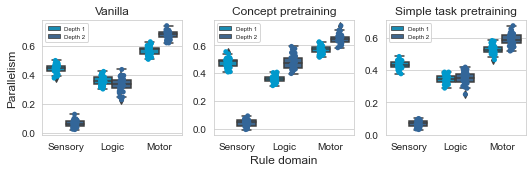

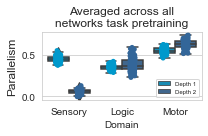

In [97]:
depth_palette = ['#0099cc','#336699']


df_ps_2rule = {}
df_ps_2rule['Depth'] = []
df_ps_2rule['Parallelism'] = []
df_ps_2rule['Domain'] = []
df_ps_2rule['Simulation'] = []

df_ps_1rule = {}
df_ps_1rule['Depth'] = []
df_ps_1rule['Parallelism'] = []
df_ps_1rule['Domain'] = []
df_ps_1rule['Simulation'] = []

df_ps_vanilla = {}
df_ps_vanilla['Depth'] = []
df_ps_vanilla['Parallelism'] = []
df_ps_vanilla['Domain'] = []
df_ps_vanilla['Simulation'] = []

for i in range(simstart,simend):
    # Concept pretraining
    tmpdf = df_adam_1rule.loc[df_adam_1rule.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_2rule['Simulation'].append(i)
            df_ps_2rule['Depth'].append('Depth ' + str(depth))
            df_ps_2rule['Domain'].append(rule)
            df_ps_2rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

    # Simple task 
    tmpdf = df_adam.loc[df_adam.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_1rule['Simulation'].append(i)
            df_ps_1rule['Depth'].append('Depth ' + str(depth))
            df_ps_1rule['Domain'].append(rule)
            df_ps_1rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])
            
    # Vanilla 
    tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==60]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_vanilla['Simulation'].append(i)
            df_ps_vanilla['Depth'].append('Depth ' + str(depth))
            df_ps_vanilla['Domain'].append(rule)
            df_ps_vanilla['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

df_ps_2rule = pd.DataFrame(df_ps_2rule)
df_ps_1rule = pd.DataFrame(df_ps_1rule)
df_ps_vanilla = pd.DataFrame(df_ps_vanilla)

plt.figure(figsize=(7.5,2.5))
plt.subplot(131)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_vanilla)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_vanilla)
plt.title('Vanilla', fontsize=12)
plt.xlabel(None,fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(132)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_1rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_1rule)
plt.title('Concept pretraining', fontsize=12)
plt.xlabel('Rule domain',fontsize=12)
plt.ylabel(None, fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(133)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_2rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_2rule)
plt.title('Simple task pretraining', fontsize=12)
plt.xlabel(None,fontsize=12)
plt.ylabel(None, fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])
plt.tight_layout()
plt.savefig('Experiment8b_PSvDepth.png', dpi=300)



print('Vanilla network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_vanilla.loc[df_ps_vanilla.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)
    
print('Concept pretrained network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_1rule.loc[df_ps_1rule.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)
    
print('Simple task pretrained network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_2rule.loc[df_ps_2rule.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)


## Average?
tmpdf_avgall = pd.concat([df_ps_2rule, df_ps_1rule, df_ps_vanilla])
plt.figure(figsize=(3,2))
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=tmpdf_avgall)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=tmpdf_avgall)
plt.title('Averaged across all\nnetworks task pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])
plt.tight_layout()
# plt.savefig('Experiment8b_PSvDepth_AvgTrainedNets.png', dpi=300)


print('Trained networks (averaged across all nets) statistical testing')
tmpdf_avg = pd.DataFrame()
tmpdf_avg['Parallelism'] = (df_ps_vanilla.Parallelism.values + df_ps_2rule.Parallelism.values + df_ps_1rule.Parallelism.values)/3.0
tmpdf_avg['Depth'] = df_ps_vanilla.Depth
tmpdf_avg['Domain'] = df_ps_vanilla.Domain
for domain in ['Sensory','Logic','Motor']:
    tmp = tmpdf_avg.loc[tmpdf_avg.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    diff = tmp.Parallelism[tmp.Depth=='Depth 1'].mean() - tmp.Parallelism[tmp.Depth=='Depth 2'].mean()
    print('\t', domain, 'Depth 1 vs. 2 =', diff, '| t =', t, '| p =', p)

# Plot "null" parallelism versus depth (i.e., zeroshot PS)

Vanilla network statistical testing
	 Sensory Depth 1 vs. 2 | t = 7.3814100363266695 | p = 1.469420980813717e-10
	 Logic Depth 1 vs. 2 | t = 6.722186930464596 | p = 2.6478922820563444e-09
	 Motor Depth 1 vs. 2 | t = 9.23418789181863 | p = 3.79347716990683e-14
Concept pretrained network statistical testing
	 Sensory Depth 1 vs. 2 | t = 67.82884945378761 | p = 4.117892244349606e-71
	 Logic Depth 1 vs. 2 | t = -12.646723325527677 | p = 1.404860394746825e-20
	 Motor Depth 1 vs. 2 | t = -12.629975120472567 | p = 1.5065272335132752e-20
Simple task pretrained network statistical testing
	 Sensory Depth 1 vs. 2 | t = 44.25179214407192 | p = 5.131962712848616e-57
	 Logic Depth 1 vs. 2 | t = -1.688989233748438 | p = 0.0952155232022023
	 Motor Depth 1 vs. 2 | t = 3.044608959899904 | p = 0.0031760315256021956


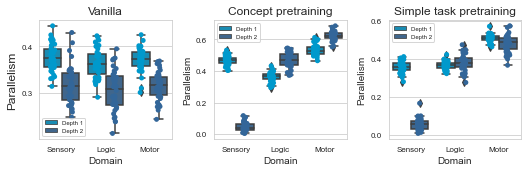

In [84]:
depth_palette = ['#0099cc','#336699']

df_ps_2rule = {}
df_ps_2rule['Depth'] = []
df_ps_2rule['Parallelism'] = []
df_ps_2rule['Domain'] = []
df_ps_2rule['Simulation'] = []

df_ps_1rule = {}
df_ps_1rule['Depth'] = []
df_ps_1rule['Parallelism'] = []
df_ps_1rule['Domain'] = []
df_ps_1rule['Simulation'] = []

df_ps_vanilla = {}
df_ps_vanilla['Depth'] = []
df_ps_vanilla['Parallelism'] = []
df_ps_vanilla['Domain'] = []
df_ps_vanilla['Simulation'] = []

for i in range(simstart,simend):
    # Concept pretraining
    tmpdf = df_adam_1rule.loc[df_adam_1rule.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_2rule['Simulation'].append(i)
            df_ps_2rule['Depth'].append('Depth ' + str(depth))
            df_ps_2rule['Domain'].append(rule)
            df_ps_2rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

    # Simple task 
    tmpdf = df_adam.loc[df_adam.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_1rule['Simulation'].append(i)
            df_ps_1rule['Depth'].append('Depth ' + str(depth))
            df_ps_1rule['Domain'].append(rule)
            df_ps_1rule['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])
            
    # Vanilla 
    tmpdf = df_adam_nopretraining.loc[df_adam_nopretraining.Simulation==i]
    tmpdf = tmpdf.loc[tmpdf.NumPracticedTasks==0]
    for depth in range(1,3):
        for rule in ['Sensory','Logic','Motor']:
            df_ps_vanilla['Simulation'].append(i)
            df_ps_vanilla['Depth'].append('Depth ' + str(depth))
            df_ps_vanilla['Domain'].append(rule)
            df_ps_vanilla['Parallelism'].append(tmpdf[rule + 'PS' + str(depth)].values[0])

df_ps_2rule = pd.DataFrame(df_ps_2rule)
df_ps_1rule = pd.DataFrame(df_ps_1rule)
df_ps_vanilla = pd.DataFrame(df_ps_vanilla)

plt.figure(figsize=(7.5,2.5))
plt.subplot(131)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_vanilla)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_vanilla)
plt.title('Vanilla', fontsize=12)
# plt.xlabel(fontsize=12)
plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(132)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_1rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_1rule)
plt.title('Concept pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
# plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])

plt.subplot(133)
ax = sns.boxplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,data=df_ps_2rule)
sns.stripplot(x="Domain",y="Parallelism",hue="Depth",palette=depth_palette,dodge=True,data=df_ps_2rule)
plt.title('Simple task pretraining', fontsize=12)
# plt.xlabel(fontsize=12)
# plt.ylabel('Parallelism', fontsize=12)
plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.legend()
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2],fontsize=6)
# plt.ylim([0,.5])
plt.tight_layout()
# plt.savefig('Experiment8b_PSvDepth_Zeroshot.png', dpi=300)

print('Vanilla network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_vanilla.loc[df_ps_vanilla.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)
    
print('Concept pretrained network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_1rule.loc[df_ps_1rule.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)
    
print('Simple task pretrained network statistical testing')
for domain in ['Sensory','Logic','Motor']:
    tmp = df_ps_2rule.loc[df_ps_2rule.Domain==domain]
    t, p = stats.ttest_ind(tmp.Parallelism[tmp.Depth=='Depth 1'],tmp.Parallelism[tmp.Depth=='Depth 2'])
    print('\t', domain, 'Depth 1 vs. 2 | t =', t, '| p =', p)
